In [19]:
import torch
import torch.nn as nn 
import torch.optim as optim  
import torchvision.transforms as transforms
import torchvision
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

Imported necessary libraries 

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounting google drive to use the data directly in colab

In [21]:
!unzip /content/drive/MyDrive/dataset.zip

Archive:  /content/drive/MyDrive/dataset.zip
replace dataset/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


unzipped the data folder containing images

In [22]:
class RegressionDataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        with open(txt_file) as f:
            self.data = f.readlines()
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        line = self.data[index].strip().split()
        img_path = os.path.join(self.root_dir, line[0])
        image = Image.open(img_path)
        target = float(line[1])

        if self.transform:
            image = self.transform(image)

        return (image, target)

Constructed custom dataset for loading data

In [23]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Necessary transformations on image

In [24]:
dataset = RegressionDataset(
    txt_file="mydata.txt",
    root_dir="dataset",
    transform=transform
)

In [25]:
dataloader = DataLoader(
    dataset,
    batch_size=10,
    shuffle=True,
    num_workers=1,
)

Constructed data loader

In [26]:
images , targets = next(iter(dataloader))

In [27]:
images.shape

torch.Size([10, 3, 224, 224])

In [28]:
targets.shape

torch.Size([10])

labels : tensor([1.2100, 0.0000, 1.2100, 0.0000, 0.0000, 0.0000, 0.0000, 0.8100, 0.0000,
        0.0000], dtype=torch.float64)


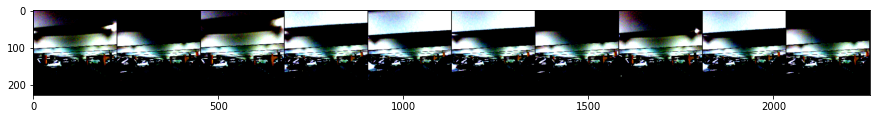

In [29]:
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print(f"labels : {targets}")

Visualization of our images

In [30]:
class CustomNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32, 64, kernel_size = 2, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Linear(56,28),
            nn.ReLU(),
            nn.Linear(28,1)
        )
    
    def forward(self, xb):
        return self.network(xb)

Buiding our custom network

In [31]:
network = CustomNetwork()
print(network)

CustomNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Linear(in_features=56, out_features=28, bias=True)
    (7): ReLU()
    (8): Linear(in_features=28, out_features=1, bias=True)
  )
)


Created an instance of our custom network

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.1)

for epoch in range(2):
    total_loss = 0
    for item in dataloader:
        images , targets = next(iter(dataloader))
        #targets = targets.float()
        targets = targets.view(-1, 1, 1, 1).float()


        preds = network(images)
        loss = criterion(preds, targets)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    avg_loss = total_loss / len(dataloader)
    print("epoch:",epoch,"loss:",avg_loss)

epoch: 0 loss: 4883.897157287598
epoch: 1 loss: 17.29355158805847


Training for a few epochs .
Everything is running well .